# Exercise 3
## Generative adversarial networks
### Generating of MNIST digits with a GAN

First we import the modules we need

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchsummary import summary

from IPython import display
import matplotlib.pylab as plt
import ipywidgets

Check that we're running on GPU, and initialize our device

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [ ]:
# number of epochs for each gan
num_epochs = 10

In [ ]:
# just for testing
test_img_sample = np.random.randn(100,28,28)

In [ ]:
# plots for report
def plotSample(samples, title):

  plt.figure(figsize = [15,3])

  for i in range(5):

    plt.subplot(1, 5, i+1)
    plt.imshow(samples[i], cmap='gray')
    plt.yticks([])
    plt.xticks([])

  plt.gcf().suptitle(title, fontsize=20)

  save_name = title.replace(' ','_') + '.pdf'
  plt.savefig(save_name, bbox_inches="tight")
  plt.show()  

  print(f'saved as {save_name}')

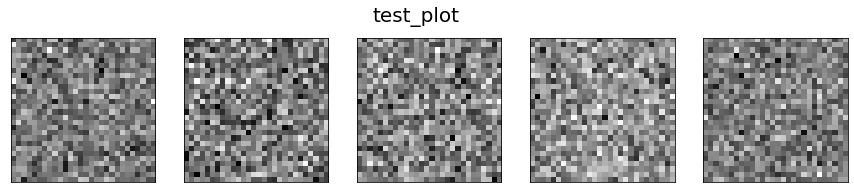

saved as test_plot.pdf


In [ ]:
# test plot
plotSample(test_img_sample, 'test_plot')

Setup our MNIST dataloaders

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5, 0.5)])#  (-1, 1)

batch_size = 64

trainset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

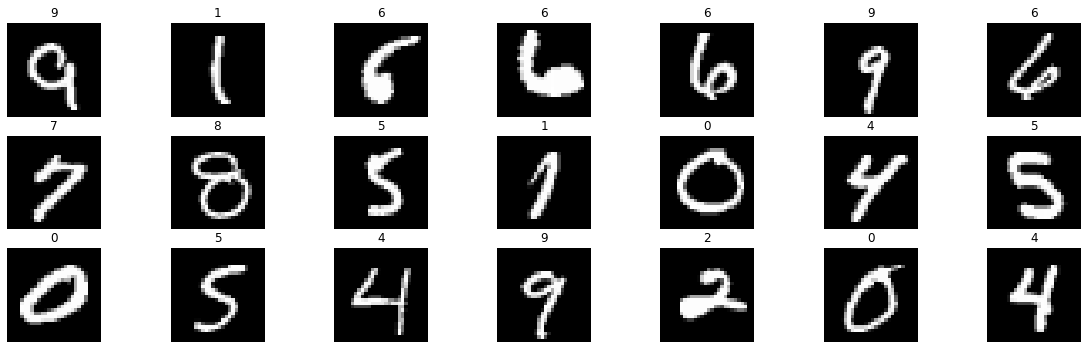

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy()[0], 'gray')
    plt.title(labels[i].item())
    plt.axis('off')

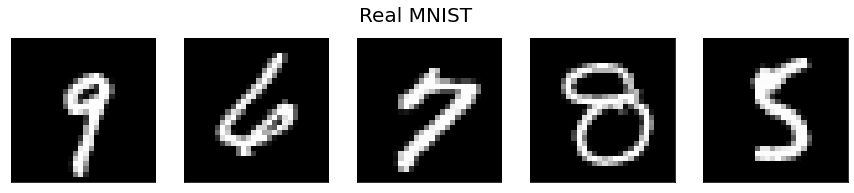

saved as Real_MNIST.pdf


In [ ]:
plotSample(images[5:,0,:,:].numpy(), 'Real MNIST')

Implement your **generator** network as a fully connected neural network.

You could start with a network that:
* takes as input a 100 long vector
* has four hidden layers with 2848 neurons
* uses LeakyReLU as the activation function
* uses BatchNorm
* has Tanh as the last layer (we work with MNIST in the -1 to 1 range)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fully_connected0 = nn.Sequential(
            nn.Linear(100, 2848), 
            nn.BatchNorm1d(2848),
            nn.LeakyReLU(0.2),
            )
        
        self.fully_connected1 = nn.Sequential(
            nn.Linear(2848,2848),
            nn.BatchNorm1d(2848),
            nn.LeakyReLU(0.2),
            )


        self.fully_connected2 = nn.Sequential(
            nn.Linear(2848,2848),
            nn.BatchNorm1d(2848),
            nn.LeakyReLU(0.2),
            )
        

        self.fully_connected3 = nn.Sequential(
            nn.Linear(2848,2848),
            nn.BatchNorm1d(2848),
            nn.LeakyReLU(0.2),
            )

        self.fully_connected4 = nn.Sequential(
            nn.Linear(2848,28*28),
            nn.Tanh()
            )
        
    def forward(self, x):

        x = self.fully_connected0(x)
        x = self.fully_connected1(x)
        x = self.fully_connected2(x)
        x = self.fully_connected3(x)
        x = self.fully_connected4(x)

        x = x.view(x.size(0), 1, 28, 28)

        return x

Implement your **discriminator** network as a fully connected neural network

Start out with a network that
* takes as input an $28\times28$ image
* has three hidden layers with [1024, 512, 256] neurons respectively
* uses LeakyReLU as the activation function
* uses Dropout
* has no activation on the final layer (we will call sigmoid if we want a probability)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.fully_connected0 = nn.Sequential(
            nn.Linear(28*28,1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3) # put it higher so the d dont learn to fast
            )
        
        self.fully_connected1 = nn.Sequential(
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
            )

        self.fully_connected2 = nn.Sequential(
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
            )

        self.fully_connected3 = nn.Sequential(
            nn.Linear(256,10))
            
    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.fully_connected0(x)
        x = self.fully_connected1(x)
        x = self.fully_connected2(x)
        x = self.fully_connected3(x)

        return x

Now let's train our model

## Standart loss:
![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/Summary-of-the-Generative-Adversarial-Network-Training-Algorithm-1024x669.png)

> “Generative Adversarial Networks. 2014”

**From https://machinelearningmastery.com/generative-adversarial-network-loss-functions/**

Described mathematically, the discriminator seeks to maximize the average of the log probability for real images and the log of the inverted probabilities of fake images.

    maximize log D(x) + log(1 – D(G(z)))

If implemented directly, this would require changes be made to model weights using stochastic ascent rather than stochastic descent.

It is more commonly implemented as a traditional binary classification problem with labels 0 and 1 for generated and real images respectively.

The model is fit seeking to minimize the average binary cross entropy, also called log loss.

    minimize y_true * -log(y_predicted) + (1 – y_true) * -log(1 – y_predicted)

...

For the GAN, the generator and discriminator are the two players and take turns involving updates to their model weights. The min and max refer to the minimization of the generator loss and the maximization of the discriminator’s loss.

    min max(D, G)

As stated above, the discriminator seeks to maximize the average of the log probability of real images and the log of the inverse probability for fake images.

    discriminator: maximize log D(x) + log(1 – D(G(z)))

The generator seeks to minimize the log of the inverse probability predicted by the discriminator for fake images. This has the effect of encouraging the generator to generate samples that have a low probability of being fake.

    generator: minimize log(1 – D(G(z)))


...

The Non-Saturating GAN Loss is a modification to the generator loss to overcome the saturation problem.

It is a subtle change that involves the generator maximizing the log of the discriminator probabilities for generated images instead of minimizing the log of the inverted discriminator probabilities for generated images.

    generator: maximize log(D(G(z)))

This is a change in the framing of the problem.

In the previous case, the generator sought to minimize the probability of images being predicted as fake. Here, the generator seeks to maximize the probability of images being predicted as real.

...

In practice, this is also implemented as a binary classification problem, like the discriminator. Instead of maximizing the loss, we can flip the labels for real and fake images and minimize the cross-entropy.

see https://machinelearningmastery.com/generative-adversarial-network-loss-functions/ for other variants


![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/Summary-of-Different-GAN-Loss-Functions.png)

— Are GANs Created Equal? A Large-Scale Study, 2018.

Surprisingly, they discover that all evaluated loss functions performed approximately the same when all other elements were held constant.

In [ ]:
# Losses:

# MM GAN
def mmGanD(x, z):
  d_loss = -(torch.mean(torch.log(torch.sigmoid(d(x)))) + torch.mean(torch.log(1 - torch.sigmoid(d(g(z).detach())))))
  return(d_loss)

def mmGanG(z):
  g_loss = torch.mean(torch.log(1 - torch.sigmoid(d(g(z)))))
  return(g_loss)


# NS GAN
def nsGanD(x, z):
  d_loss = -(torch.mean(torch.log(torch.sigmoid(d(x)))) + torch.mean(torch.log(1 - torch.sigmoid(d(g(z).detach())))))
  return(d_loss)

def nsGanG(z):
  g_loss = -torch.mean(torch.log(torch.sigmoid(d(g(z)))))
  return(g_loss)



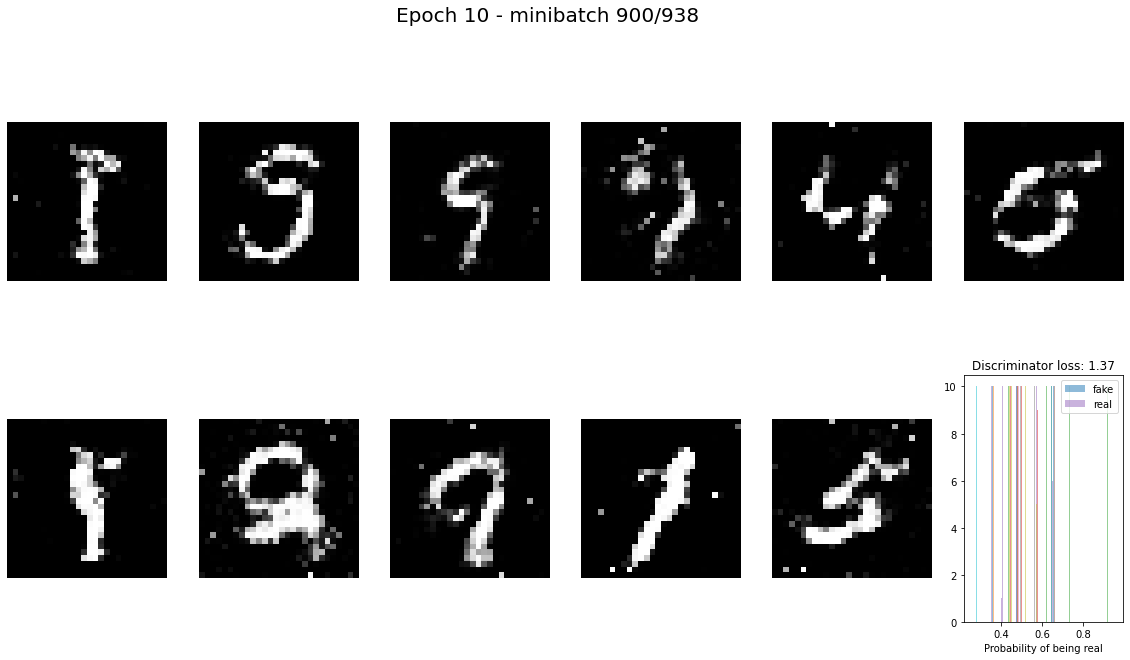

In [ ]:
#Initialize networks
d = Discriminator().to(device)
g = Generator().to(device)
d_opt = torch.optim.Adam(d.parameters(), 0.0004, (0.5, 0.999))
g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
# num_epochs = 10
discriminator_final_layer = torch.sigmoid # Oh, its here. I put it in the losses..

for epoch in range(num_epochs):
    for minibatch_no, (x, target) in enumerate(train_loader):
        x_real = x.to(device)
        z = torch.randn(x.shape[0], 100).to(device)
        x_fake = g(z)
        #Update discriminator
        d.zero_grad()
        #remember to detach x_fake before using it to compute the discriminator loss
        #otherwise the discriminator loss will backpropagate through the generator as well, which is unnecessary.

        # D        
        # d_loss = mmGanD(x, z)# works best
        d_loss = nsGanD(x_real, z)# works
        d_loss.backward()
        d_opt.step()

        # G
        g.zero_grad()
        # g_loss = mmGanG(z)#works best
        g_loss = nsGanG(z)# works
        g_loss.backward()
        g_opt.step()
        
        assert(not np.isnan(d_loss.item()))
        #Plot results every 100 minibatches
        if minibatch_no % 100 == 0:
            with torch.no_grad():
                P = discriminator_final_layer(d(x_fake))
                for k in range(11):
                    x_fake_k = x_fake[k].cpu().squeeze()/2+.5
                    subplots[k].imshow(x_fake_k, cmap='gray')
                    # subplots[k].set_title('d(x)=%.2f' % P[k])
                    subplots[k].axis('off')
                z = torch.randn(batch_size, 100).to(device)
                
                H1 = discriminator_final_layer(d(g(z))).cpu() # her
                H2 = discriminator_final_layer(d(x_real)).cpu() # her

                plot_min = min(H1.min(), H2.min()).item()
                plot_max = max(H1.max(), H2.max()).item()
                subplots[-1].cla()
                subplots[-1].hist(H1.squeeze(), label='fake', range=(plot_min, plot_max), alpha=0.5)
                subplots[-1].hist(H2.squeeze(), label='real', range=(plot_min, plot_max), alpha=0.5)
                subplots[-1].legend()
                subplots[-1].set_xlabel('Probability of being real')
                subplots[-1].set_title('Discriminator loss: %.2f' % d_loss.item())
                
                title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
                plt.gcf().suptitle(title, fontsize=20)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                

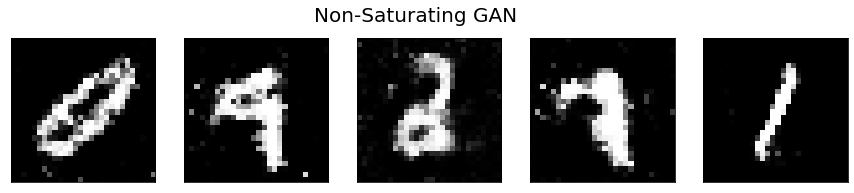

saved as Non-Saturating_GAN.pdf


In [ ]:
plotSample(x_fake[:,0,:,:].cpu().detach().numpy(), 'Non-Saturating GAN')

# WGAN
https://wiseodd.github.io/techblog/2017/02/04/wasserstein-gan/  
https://github.com/caogang/wgan-gp/blob/master/gan_mnist.py  
https://github.com/martinarjovsky/WassersteinGAN/blob/master/main.py

![alt text](https://wiseodd.github.io/img/2017-02-04-wasserstein-gan/00.png)

In [ ]:
# WGAN
def wGanD(x, z):
  d_loss = -(torch.mean(d(x)) - torch.mean(d(g(z).detach()))) #you do not take log, so you do not need sigmoid, maximizes the function D(x), and it also minimizes D(G(z)).
  return(d_loss)

def wGanG(z):
  g_loss = - torch.mean(d(g(z))) # you do not take log, so you do not need sigmoid. maximizes D(G(z)).
  return(g_loss)

# # WGAN GP
# def wGanGpD(x, z):
#   d_loss = ...
#   return(d_loss)

# def wGanGpG(z):
#   g_loss = ...
#   return(g_loss)


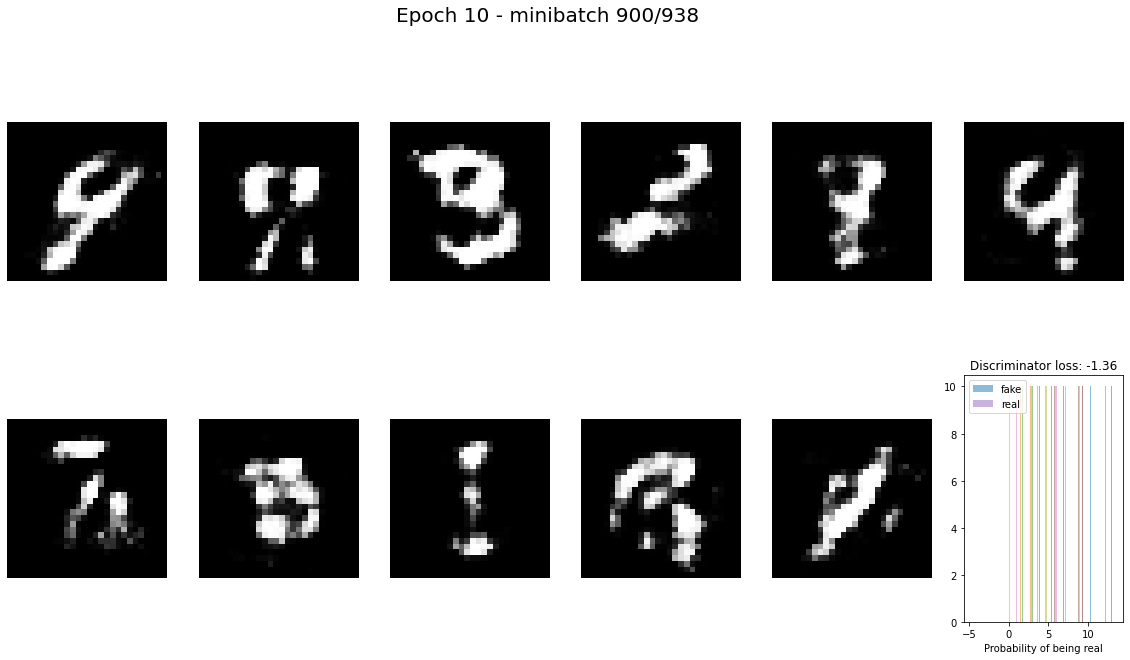

In [ ]:

# Needs the whole critic thing
c = 0.01
n_crit = 5

#Initialize networks
d = Discriminator().to(device)
g = Generator().to(device)

# # original wgan uses, since problem with momentum/adam:
g_opt = torch.optim.RMSprop(g.parameters(), lr=5e-5)
d_opt = torch.optim.RMSprop(d.parameters(), lr=5e-5)


plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
# num_epochs = 10

for epoch in range(num_epochs):
  for minibatch_no, (x, target) in enumerate(train_loader):
    for _ in range(n_crit): # critic
      x_real = x.to(device) #scale to (-1, 1) range

      z = torch.randn(x.shape[0], 100).to(device)
      x_fake = g(z)
      #Update discriminator
      d.zero_grad()
      #remember to detach x_fake before using it to compute the discriminator loss
      #otherwise the discriminator loss will backpropagate through the generator as well, which is unnecessary.
        
      d_loss = wGanD(x_real, z)
      d_loss.backward()
      d_opt.step()

      # clamp weights for K-Lipschiz - wgan2 propose gradient penalty instead of weight clipping
      for p in d.parameters():
        p.data.clamp_(-c, c)

    #Update generator. You should actually sample new z right?
    g.zero_grad()
    g_loss = wGanG(z)
    g_loss.backward()
    g_opt.step()
        
    assert(not np.isnan(d_loss.item()))
    #Plot results every 100 minibatches
    if minibatch_no % 100 == 0:
      with torch.no_grad():
        for k in range(11):
          x_fake_k = x_fake[k].cpu().squeeze()/2+.5
          subplots[k].imshow(x_fake_k, cmap='gray')
          # subplots[k].set_title('d(x)=%.2f' % P[k])
          subplots[k].axis('off')
                
        z = torch.randn(batch_size, 100).to(device)

        H1 = d(g(z)).cpu() # her
        H2 = d(x_real).cpu() # her

        plot_min = min(H1.min(), H2.min()).item()
        plot_max = max(H1.max(), H2.max()).item()
        subplots[-1].cla()
        subplots[-1].hist(H1.squeeze(), label='fake', range=(plot_min, plot_max), alpha=0.5)
        subplots[-1].hist(H2.squeeze(), label='real', range=(plot_min, plot_max), alpha=0.5)
        subplots[-1].legend()
        subplots[-1].set_xlabel('Probability of being real')
        subplots[-1].set_title('Discriminator loss: %.2f' % d_loss.item())
                
        title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
        plt.gcf().suptitle(title, fontsize=20)
        display.display(plt.gcf())
        display.clear_output(wait=True)
                

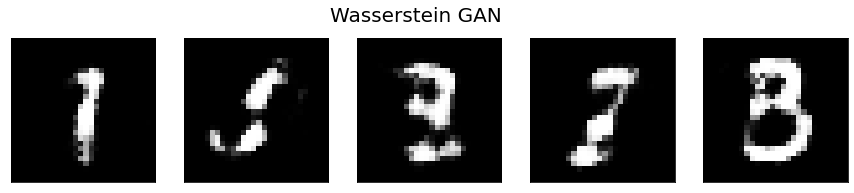

saved as Wasserstein_GAN.pdf


In [ ]:
plotSample(x_fake[:,0,:,:].cpu().detach().numpy(), 'Wasserstein GAN')

# Least Square Loss!

In [ ]:

# LS GAN: as sper paper
def lsGanD(x, z):
  d_loss = (1/2) * torch.mean((d(x)-1)**2) + (1/2) * torch.mean((d(g(z))+1)**2)
  return(d_loss)

def lsGanG(z):
  g_loss = (1/2) * torch.mean((d(g(z)))**2)
  return(g_loss)

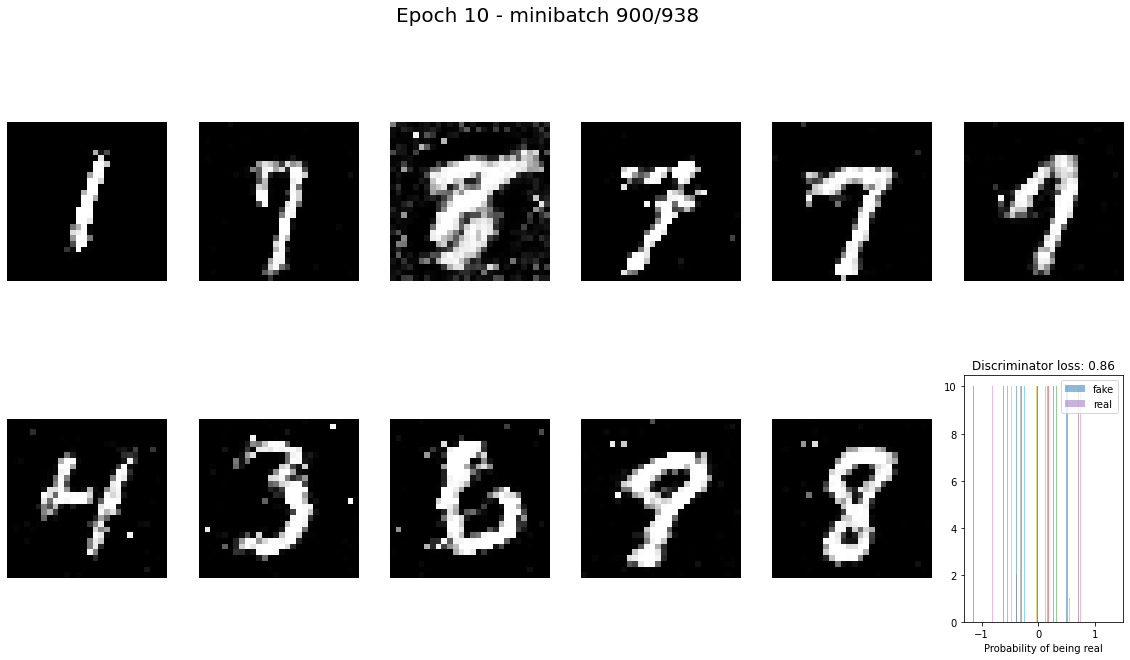

In [ ]:
#Initialize networks
d = Discriminator().to(device)
g = Generator().to(device)

d_opt = torch.optim.Adam(d.parameters(), 0.0004, (0.5, 0.999))
g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
# num_epochs = 10

for epoch in range(num_epochs):
    for minibatch_no, (x, target) in enumerate(train_loader):
        x_real = x.to(device)
        z = torch.randn(x.shape[0], 100).to(device)
        x_fake = g(z)
        #Update discriminator
        d.zero_grad()
        #remember to detach x_fake before using it to compute the discriminator loss
        #otherwise the discriminator loss will backpropagate through the generator as well, which is unnecessary.

        # D        
        d_loss = lsGanD(x_real, z)# works
        d_loss.backward()
        d_opt.step()

        # G
        g.zero_grad()
        g_loss = lsGanG(z)# works
        g_loss.backward()
        g_opt.step()
        
        assert(not np.isnan(d_loss.item()))
        #Plot results every 100 minibatches
        if minibatch_no % 100 == 0:
            with torch.no_grad():
                for k in range(11):
                    x_fake_k = x_fake[k].cpu().squeeze()/2+.5
                    subplots[k].imshow(x_fake_k, cmap='gray')
                    # subplots[k].set_title('d(x)=%.2f' % P[k])
                    subplots[k].axis('off')
                z = torch.randn(batch_size, 100).to(device)
                
                H1 = d(g(z)).cpu() # her
                H2 = d(x_real).cpu() # her

                plot_min = min(H1.min(), H2.min()).item()
                plot_max = max(H1.max(), H2.max()).item()
                subplots[-1].cla()
                subplots[-1].hist(H1.squeeze(), label='fake', range=(plot_min, plot_max), alpha=0.5)
                subplots[-1].hist(H2.squeeze(), label='real', range=(plot_min, plot_max), alpha=0.5)
                subplots[-1].legend()
                subplots[-1].set_xlabel('Probability of being real')
                subplots[-1].set_title('Discriminator loss: %.2f' % d_loss.item())
                
                title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
                plt.gcf().suptitle(title, fontsize=20)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                

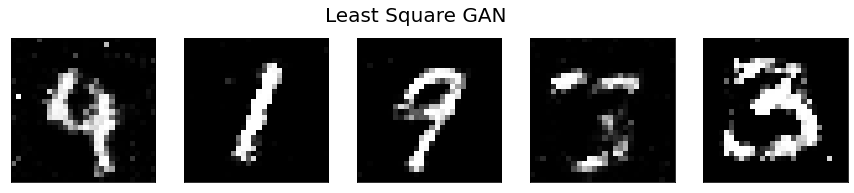

saved as Least_Square_GAN.pdf


In [ ]:
plotSample(x_fake[:,0,:,:].cpu().detach().numpy(), 'Least Square GAN')

# Other losses


In [ ]:

# DRAGAN
# def DGanD(x, z):
#   d_loss = ...
#   return(d_loss)

# def DGanG(z):
#   g_loss = ...
#   return(g_loss)

# BEGAN
# def BGanD(x, z):
#   d_loss = ...
#   return(d_loss)

# def BGanG(z):
#   g_loss = ...
#   return(g_loss)

# Second implimentation
**DCGAN**
inspired by code here: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html  
and here
https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN/blob/master/pytorch_MNIST_DCGAN.py


"A DCGAN is a direct extension of the GAN described above, except that it explicitly uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively. It was first described by Radford et. al. in the paper Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks. The discriminator is made up of strided convolution layers, batch norm layers, and LeakyReLU activations. The input is a 3x64x64 input image and the output is a scalar probability that the input is from the real data distribution. The generator is comprised of convolutional-transpose layers, batch norm layers, and ReLU activations. The input is a latent vector, z, that is drawn from a standard normal distribution and the output is a 3x64x64 RGB image. The strided conv-transpose layers allow the latent vector to be transformed into a volume with the same shape as an image. In the paper, the authors also give some tips about how to setup the optimizers, how to calculate the loss functions, and how to initialize the model weights, all of which will be explained in the coming sections."


### Weight Initialization

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.